#Imports

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 6.3 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
     |████████████████████████████████| 6.8 MB 34.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import torch
import seaborn as sns
import numpy as np
import random
import time
import datetime
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocessing

In [4]:
data = "/content/drive/MyDrive/TER2021/data_preprocessed.csv"
df = pd.read_csv(data).drop(['Unnamed: 0'],axis=1)


print(df)

                                                  topic  ...       eType
0     This house believes that the sale of violent v...  ...   [STUDY]\n
1     This house believes that the sale of violent v...  ...   [STUDY]\n
2     This house believes that the sale of violent v...  ...   [STUDY]\n
3     This house believes that the sale of violent v...  ...   [STUDY]\n
4     This house believes that the sale of violent v...  ...   [STUDY]\n
...                                                 ...  ...         ...
4687  This house would enforce term limits on the le...  ...  [EXPERT]\n
4688  This house would enforce term limits on the le...  ...  [EXPERT]\n
4689  This house would enforce term limits on the le...  ...  [EXPERT]\n
4690  This house would enforce term limits on the le...  ...   [STUDY]\n
4691  This house would enforce term limits on the le...  ...  [EXPERT]\n

[4692 rows x 4 columns]


Here a function to merge columns for each rows.

In [5]:
datamerged = pd.DataFrame(columns = ["value"])

for index,row in df.iterrows():
    sentence = row['topic'] + " " + row['claim'] + " "+row['evidence']
    datamerged.loc[index] = sentence
  
datamerged.dropna(inplace=True)
datamerged = datamerged.value.copy()


In [6]:
print(datamerged)

0       This house believes that the sale of violent v...
1       This house believes that the sale of violent v...
2       This house believes that the sale of violent v...
3       This house believes that the sale of violent v...
4       This house believes that the sale of violent v...
                              ...                        
4687    This house would enforce term limits on the le...
4688    This house would enforce term limits on the le...
4689    This house would enforce term limits on the le...
4690    This house would enforce term limits on the le...
4691    This house would enforce term limits on the le...
Name: value, Length: 4692, dtype: object


In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#Dataset Pytorch

In [8]:
batch_size = 2

In [9]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [10]:
dataset = GPT2Dataset(datamerged, tokenizer, max_length=768) 

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,222 training samples
  470 validation samples


In [11]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

#Finetune

In [12]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [13]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

In [14]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [15]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [16]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [17]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,111. Loss: 0.2882936894893646.   Elapsed: 0:00:50.
0:  bipartisan" has brought experience with Democrats' "unearned" votes to make votes a number of small house of representatives who want to most than to even get as many as they want to be elected were just a and minority of Democrats who both supported the repeal of the Affordable Care Act and the repeal of the Affordable Care Act were just a small minority of Republicans who voted for the repeal of the Affordable Care Act and the repeal of the insurance law.

 he had the number of leaders that want to make at least one million and an average of two million. He had the number of members who had been in the past, among them, a number of white male and Hispanic women, who have been voting for the repeal of the Affordable Care Act and the repeal policy of the individual mandate and the repealing


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,111. Loss: 0.24635544419288635.   Elapsed: 0:01:46.
0:  increasingThis house would limit the rights of religions to profess the existence of such beliefs as the existence of some deity and of atheism, and to restrict the rights of others to profess such beliefs as the existence of some deity. This ban would be contrary to the First Amendment and other free expression rights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,111. Loss: 0.35488298535346985.   Elapsed: 0:02:40.
0: dayThis house supports Israel's right to protect itself from rocket attacks and the rocket attacks of Hamas A rocket was fired evening by Israeli police day after President Mahmoud Ahmadinejad called for Israel to stop firing rockets into Gaza. Ahmadinejad said Israel's attacks are illegal and called on the Palestinian Authority to Ministry of Foreign Affairs to UN that Hamas is no more than an apartheid state. He said Israel's rockets, fired morning after Israel lost its first combat, should be fired by Palestinians who are fighting in the Gaza Strip. He added, "Such attacks against Israel are neither justified nor sanctioned by Israel, which must respect international humanitarian law and safeguard the citizens and property of Israel."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,111. Loss: 0.3482207953929901.   Elapsed: 0:03:35.
0:  HangThis house believes atheism is the only way religion can be effective at solving problems Religion is therefore crucial for social cohesion and peace in the contemporary society According to Sh principle, any human being's humanity is compromised by the existence of a rival caste and the state must take initiative to protect its citizens from the forces of rival groups A correlation was found between the rise of religiously sanctioned racial and cultural hatreds and the rise of xenophobia and other forms of animosity among many societies The study, based on the testimonies of individuals in various studies and the findings of human rights groups and NGO workers, found that the number of people seeking asylum in Sweden, Sweden, Denmark and Germany decreased between 1986 and 1992, from total population to 130,000 (as opposed to the 50,000 per in Australia). According to Sh, a systematic effort by the Governme

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,111. Loss: 0.33726197481155396.   Elapsed: 0:04:31.
0:  foodsThis house believes that wind power should be a primary focus of future energy supply Wind power should be a primary focus of future energy supply The US Department of Energy (DOE) estimates that wind power will generate about a quarter of the world's greenhouse dioxide emissions (GHG) each year [REF]. These emissions have largely been reduced in the past 40 years by the use of wind power [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,111. Loss: 0.35976123809814453.   Elapsed: 0:05:25.
0:  trailThis house supports the one-child policy of the republic of China The notion that the Chinese need to adopt the one-child policy of the republic of China was rejected by the Thirteenth Council of Great Britain in 18 Progress of the World, an International Journal of Population, Development and Food Security, published by the Society for the Study of Population and Development, and led by William Hague of U.N.IPA, said: "The Chinese should adopt a policy which would limit the access to contraceptives and the importation of infantiles and young children, and not allow the establishment of a separate population, and which would prohibit the use of contraceptives, contraceptives which are sometimes deemed by Chinese to be dangerous to human health and the well-being of their children


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,111. Loss: 0.2990080416202545.   Elapsed: 0:06:21.
0: intendThis house believes that male infant circumcision is tantamount to child abuse the Medical College of Australia believes the "medical establishment is deeply concerned about these findings. It believes that the medical establishment is deeply concerned about these findings


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,111. Loss: 0.2783966362476349.   Elapsed: 0:07:14.
0:  surroundThis house would prohibit burning the stars and stripes Flag burning is protected speech under the First Amendment in the United States, no country has the right to flag its citizens as "obsessed with their own country" as was the case during the Cold War. This was true prior to the Second Amendment to the United States amendment, or the Fourteenth Amendment to the United States Constitution, which was derived from the United States Constitution. The Supreme Court majority in Brown, J. holding that freedom of expression of views and opinions cannot be protected without the protection of the First Amendment, and the Court held that the Second Amendment protects speech on the stage of war, not on the floor of the home. This was followed by the rest of the court in Heller, B.& E. holding that the First Amendment does not give anyone freedom to insult the government, and that the Court held that free expres

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,111. Loss: 0.3724316954612732.   Elapsed: 0:08:11.
0:  reflexThis house believes that Israel's 2008-2009 military operations against Gaza were justified Hamas started the conflict by firing rockets On December 28, a suicide rocket was fired at the southern city of Sderot on a Christian ministry in Tel Aviv, killing three policemen and wounding more than a hundred others, a police official said. The police official, Hana Barzil, said that they discovered the dead bodies of three policemen and another man in their cars [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,111. Loss: 0.244865283370018.   Elapsed: 0:09:05.
0:  displayThis house would remove United States military bases from Japan In January, the Permanent Representative of Japan to the Nuclear Non-Aligned Movement, Yotogoyo Koyo, called on the world's leaders and the governments of the Kingdom and of the United States to support Japan's continuing development of its nuclear deterrent. He said that Japan remains the leader in the region and that the Nuclear Weapon States (Mukushin) Treaty is not adequate to protect the rights and freedoms of its people, and that Japan's citizens and international law are at the bottom of the moral and economic problems of the world. He said that Japan's peaceful treaty with the other nations of the International Criminal Union (ICCU) and the Convention against Nuclear Weapon States (CTC) do not allow for peaceful coexistence, interdependence, or territorial or other territoriality of an occupying power


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,111. Loss: 0.13802412152290344.   Elapsed: 0:10:00.
0:  pastorThis house would criminalize blasphemy The most extreme right in our constitutional system is the freedom to associate The right to freedom of thought, press and freedom of thought is not absolute. Freedom of expression includes freedom to share, impart or promote ideas and opinions whatever. For too long the right to freedom of opinion was recognized as the Fundamental Rights of man. But this recognition has been denied in constitutional limbo [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,111. Loss: 0.24574454128742218.   Elapsed: 0:10:55.
0:  illicitThis house believes that Israel should lift the blockade of Gaza Palestinians are entitled to legal protection under international law President Mahmoud Abbas called for an immediate halt to Israel's actions in the Gaza Strip [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,111. Loss: 0.46691539883613586.   Elapsed: 0:11:48.
0:  LiberationThis house believes that Holocaust denial should be a criminal offence According to one of the authors of the book The holocaust, Dr. Leo Mehrabian, "Holocaust denial has now become one of the most popular, well-informed and popular messages in modern times",[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,111. Loss: 0.1686587929725647.   Elapsed: 0:12:43.
0:  NamThis house believes that it is sometimes right for the government to restrict freedom of speech Freedom of expression and disseminating ideas are recognized as fundamental human rights by the Declaration of the Rights of Man According to his Universal Declaration of Human Rights, there is no need for any fundamental right to be asserted in any way whatsoever and no need for the establishment of any particular party, organization or any particular way of ruling by anyone. And that this principle applies regardless of any particular party, organization or any particular way of ruling any particular political sentiment


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,111. Loss: 0.05490589141845703.   Elapsed: 0:13:37.
0: IONThis house believes that Israel's 2008-2009 military operations against Gaza were justified during Operation Cast Lead, the IDF did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare Foreign Minister Carl Bildt harshly criticised Israel's move to ease the blockade of Gaza


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,111. Loss: 0.21888138353824615.   Elapsed: 0:14:32.
0:  glimpseThis house believes that Holocaust denial should be a criminal offence it is better to publish inaccurate information than to promote it The term "Holocaust denier" has been used around the world in media forms, particularly on the internet


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,111. Loss: 0.25084081292152405.   Elapsed: 0:15:26.
0:  LaureThis house believes the United States is responsible for Mexico's drugs war According to a July 2010 report by the U.S. Department of Justice, the number of weapons, munitions and funds recovered from Mexico's cartels' arms traffickers is more than doubled, reaching $360 million per year in 2011. There is also a 25% increase on the previous year [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,111. Loss: 0.2309720516204834.   Elapsed: 0:16:20.
0: ismThis house believes that Israel should lift the blockade of Gaza The blockade amounts to a flagrant violation of international law The UN's envoy, Miguel d'Escoto Brockmann, issued a report saying that the blockade, imposed in self-defence during the Gaza offensive was legal. After analysis of the impact, it was apparent that the damage had been caused by Hamas' way of fighting, which had allowed for the high-speed passage of rockets, and which had prevented much of the raid's offensive before. During the operation, which began around morning on 31 May, a missile struck the doorway of the UN's offices in Sderot. It struck the doorway again around 2am and caused a commotion. Then, about 2.30am, a missile struck the window of UN Office Sapiens Mission Operations' office in Sderot. Mission Operations was also damaged. The Mission Office was unable to return to Sderot and had to lift its blockade of the site. Mis

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,111. Loss: 0.2402389645576477.   Elapsed: 0:17:16.
0: ounThis house believes all nations have a right to nuclear weapons the spread of nuclear weapons, by anyone other than their creators, is a violation of international law On December 27, 2006, in South Africa, United Nations Deputy Special Rapporteur Miguel d'Escoto Brockmann called for an end to the rocket launches. Although he criticized the rocket launches as a violation of international law, he stated that "The rocket launches are a violation of international law. The International community cannot and must not be allowed to remain idle."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,111. Loss: 0.17335942387580872.   Elapsed: 0:18:09.
0:  electionThis house would criminalize blasphemy it's a crime to insult God or other religious beliefs, or for a political purpose, or otherwise The minister of foreign affairs for the Islamic Republic of Iran Mohammad Awad has condemned an attack on the family gathered in the outskirts of Manjaliya, where the capital is located


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,111. Loss: 0.4324706792831421.   Elapsed: 0:19:02.
0:  crazyThis house believes social deprivation causes crime rates are associated with the type of crime rate is associated with those characteristics a 1999 paper published in the British Medical Journal of the United Kingdom, found that "the very smallest of the patterns of homicide rates is associated to a poverty measure" [REF

  Average training loss: 0.33
  Training epoch took: 0:19:09

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:40

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,111. Loss: 0.10228985548019409.   Elapsed: 0:00:53.
0:  benchThis house believes atheism is the only way Religions teachings are outdated or outmodified According to Dr. William Easterly, Religion flourishes as long as religious belief is inductively accepted into the fabric of society, along with all the necessary principles of justice, religion and civil liberties [REF]. In order to fully develop its value, Easterly proposes the following method of reasoning, which he says is necessary for every religious conviction that an understanding of the Laws of God leads to the highest standard of ethical conviction


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,111. Loss: 0.18158148229122162.   Elapsed: 0:01:46.
0:  incorporatedThis house believes that Israel's 2008-2009 military operations against Gaza were justified the Israeli soldiers at best failed to protect civilians, and at worst deliberately shot at them French Foreign Minister Jean-Jacques Rousseau said "It is clear that the attacks are launched from Gaza. The attacks are a direct consequence of Hamas’ attacks on Israeli settlements in the Gaza Strip" [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,111. Loss: 0.1152992695569992.   Elapsed: 0:02:39.
0: PeterThis house would re-engage with Myanmar Burma's human rights record has been improving A significant deterioration of the human rights of many Burmese has occurred since the transition of Burma into a new government in August 2011, Burma's human rights record has been improving [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,111. Loss: 0.0476631298661232.   Elapsed: 0:03:32.
0: uringThis house would criminalize blasphemy The right to freedom of thought and expression is protected under the First Amendment The University of Michigan Law School Professor John Lott, the President of the United States, the Council of the United States Constitution, the Declaration of Teheran and the International Covenant on Economic, Social and Cultural Rights also recognize the right to freedom of thought and expression but believe that such a state of affairs should not be allowed in order to justify their imposition upon the rights of others. Lott's statement follows a statement by the President of the United States and the U.S. President of the European Commission on Humanitarian Law Applicable to Certain Crimes committed in the course of an armed conflict by member states in the European Union and, where applicable, the entire world by reference


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,111. Loss: 0.08566892147064209.   Elapsed: 0:04:26.
0:  reproductiveThis house believes that the sale of violent video games to minors should be banned No evidence has found that violent games are psychologically harmful, with reports ranging from violence in children to bullying in teenagers On June 7, 2003, 21-year-old American Devin Moore shot dead two policemen and a dispatcher after grabbing one of the officers' weapons following an arrest for the possession of a stolen vehicle. At 17,000 feet, Moore had become the first armed victim of the Columbine Massacre, the worst crime in the nation's history. A total of 19 officers and 20 firefighters were injured during the massacre, many of whom were civilians and children


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,111. Loss: 0.15922334790229797.   Elapsed: 0:05:20.
0:  zoneThis house believes that the sale of violent video games to minors should be banned There is no connection between media violence and real life violence in real life A meta analysis of previous studies has suggested media violence in real life may not be present at all in some violent games, due to exposure to media violence


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,111. Loss: 0.14184093475341797.   Elapsed: 0:06:13.
0:  commitsThis house would permit the use of performance enhancing drugs in professional sports The BMA has established that male athletes are more likely to be injured in professional sports One study found that in addition to the risk of injured individuals, exposure to performance-enhancing drugs produces a higher incidence of injuries [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,111. Loss: 0.06525538861751556.   Elapsed: 0:07:06.
0:  ironyThis house would ban gambling The majority view that states have the right to regulate their own economies and the rules of war are constitutional The majority view that states have the right to regulate their own economies and the rules of war are constitutional In a 1991 case heard by the Court, the Court stated that "the majority view that states have the right to regulate their own economies and the rules of war are constitutional


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,111. Loss: 0.13179893791675568.   Elapsed: 0:08:00.
0:  SahThis house believes that Israel's 2008-2009 military operations against Gaza were justified during the conflict, the Israel Defense Forces "did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare The Bahraini Parliament Council strongly condemned the Israeli air strikes of Palestinian territory, considering that it constituted a violation of international humanitarian law, and that "the offence of killing civilians is a war crime


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,111. Loss: 0.14623446762561798.   Elapsed: 0:08:53.
0:  BryanThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israel targeted Palestinian civilians as a matter of policy On April 1, 2011, the BBC reported that Scores [of Palestinian rockets] had struck the al-Maqadmah mosque in Gaza City. Four people were killed and dozens wounded when the Israeli army took control. The next day, the BBC reported that more than 700 people were killed and 40 wounded as a result of the attack. Civilians, including children, were killed and 40 wounded as a result of the attack


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,111. Loss: 0.08120324462652206.   Elapsed: 0:09:47.
0:  spiritsThis house believes the US is justified in using force to prevent states from acquiring nuclear weapons no issue carries more importance to the long-term health and security of humanity than the effort to reduce, and perhaps one day, rid the world of nuclear weapons The InterAcademy Nuclear Policy Treaty, signed on September 12, 2006, with the intention of turning the world into a Nuclear Age, was signed by India and Pakistan, following the disastrous failure of the U.S. in the early 1960s and the Reagan administration's decision in the late 1980s to pull out of the treaty in favour of a rival, and again the Cold War ensued


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,111. Loss: 0.03650990128517151.   Elapsed: 0:10:41.
0:  seesThis house believes that Israel's 2008-2009 military operations against Gaza were justified Palestinian armed groups committed war crimes Eleven Israelis have been killed by Hamas rocket attacks since the beginning of January 2008 [REF]. Six rockets were fired from Gaza into Israel in response to rockets fired from Hamas' rocket militant group al-Aqsa Martyr’ [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,111. Loss: 0.4171653985977173.   Elapsed: 0:11:34.
0:  hungryThis house believes that Holocaust denial should be a criminal offence Holocaust denial is a convenient polemical substitute for anti-semitism The most prominent neo-Nazi is John Faurisson, who has said he does not believe in the holocaust [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,111. Loss: 0.03635159134864807.   Elapsed: 0:12:27.
0:  PTThis house believes that male infant circumcision is tantamount to child abuse circumcision may result in psychological harm Milos and Macris (1992) argue that circumcision on newborns causes severe pain, anxieties over time, and physiologic stress [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,111. Loss: 0.06567474454641342.   Elapsed: 0:13:20.
0: üThis house would abolish the monarchy The monarchy is an outdated and regressive institution In 1968, the then Parliamentary Assembly of the Council of Europe in Strasbourg adopted Articles 10 and 11 which reaffirmed the monarchy as an obsolete and regressive institution [REF]. Article 11 of the Council's resolution reaffirmed its commitment to the monarchy as an entity separate from the state and recognized in the International Constitution


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,111. Loss: 0.1246437057852745.   Elapsed: 0:14:13.
0: ruceThis house believes that Israel should lift the blockade of Gaza The situation in Gaza is unsustainable and unacceptable In July, the International Committee of the Red Cross noted that "the increasing scarcity of items has led to rises in cost of goods while quality has fallen" [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,111. Loss: 0.1614810824394226.   Elapsed: 0:15:06.
0:  derivativesThis house would only teach abstinence for sex education in schools sexual behavior after puberty is a given, and it is therefore crucial to provide information about the risks and how they can be minimized The American Psychological Association,[REF] the American Medical Association,[REF] the National Association of School Psychologists,[REF] the Society for Adolescent Medicine,[REF] the American Academy of Pediatrics,[REF] the Society for Adolescent Medicine[REF] and the American College Health Association,[REF] argue that sexual behavior after puberty is a given, and it is therefore crucial to provide information about the risks and how they can be minimized; they also claim that denying teens such factual information leads to unwanted pregnancies and STIs


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,111. Loss: 0.1303531378507614.   Elapsed: 0:16:00.
0: This house would ban all unsustainable logging Predictions have been made that without a significant period of forest cover, almost all of the world's known biodiversity could be destroyed by the rainforest [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,111. Loss: 0.16969034075737.   Elapsed: 0:16:53.
0:  rememberingThis house would limit the right to bear arms Laws that forbid the carrying of arms in public places cause crime In the cities and villages where guns are frequently used, the risk of being attacked from an increase of 100&nbsp; a good amount of time may be averted with armed people. Armed people help to prevent crime, but they do not prevent homicides as a result of gun possession [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,111. Loss: 0.07153037190437317.   Elapsed: 0:17:46.
0:  SourcesThis house would only teach abstinence for sex education in schools Abstinence-only sex education has failed According to the AMA, “There is no evidence that abstinence-only sex education programs that provide information about HIV prevention, contraception, and sexual abstinence have successful outcomes” (AMA, 2007


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,111. Loss: 0.07357527315616608.   Elapsed: 0:18:39.
0: emsThis house believes that Israel's 2008-2009 military operations against Gaza were justified the military solution won't conduct to peace Prime Minister Ehud Olmert has expressed doubts about the legitimacy of the truce in public talks between Hamas and Hamas and remained thematic leader behind it during the latter's operation in Gaza [REF

  Average training loss: 0.15
  Training epoch took: 0:18:46

Running Validation...
  Validation Loss: 0.14
  Validation took: 0:00:40

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,111. Loss: 0.03770776465535164.   Elapsed: 0:00:52.
0: tzThis house believes that male infant circumcision is tantamount to child abuse circumcision should be presented as an option for health benefits The penis is thought to protect against STD transmission The foreskin protects the body against phimosis and can be useful for the prevention of STD transmission [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,111. Loss: 0.030243299901485443.   Elapsed: 0:01:45.
0: maticThis house would only teach abstinence for sex education in schools early sexual activity - whether in or out of a romantic relationship - does far more harm than good In a 1995 study that analyzed 133 sexually active American men, the researchers found that "only 15% of sexually active men who had sex at age 18 had sex at the same time, at least once during their teenage years" [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,111. Loss: 0.07195127010345459.   Elapsed: 0:02:39.
0:  syndThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israeli citizens in the south have been suffering from rockets being fired at them Also in 2009, in Tel Aviv, a spokeswoman for the Sderot Hosen Center, reported that 80 percent of the fire had been caused by Israelis despite evidence of their intentions to attack. Sderot Hosen Center, a branch of the Sderot Hosen Center, believed that 80 percent of the fire had been caused by Israelis despite evidence of their intentions to attack. Sderot Hosen Center said that despite evidence of their intentions, they had not intentionally bombed or anything in particular targeted civilians, even after controlling for other factors [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,111. Loss: 0.13581758737564087.   Elapsed: 0:03:33.
0:  gamThis house believes that Israel should lift the blockade of Gaza The blockade amounts to a flagrant contravention of international human rights and humanitarian law In July 2010, the UN investigative committee said that the Israeli blockade of Gaza was legal


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,111. Loss: 0.07410382479429245.   Elapsed: 0:04:26.
0:  injuryThis house would permit the use of performance enhancing drugs in professional sports There is no clear division between the amount of physical exercise performed at the Olympic Games and the level of mental well-being following years of drug abuse,[REF] and the physical ability of most professional boxers [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,111. Loss: 0.12650181353092194.   Elapsed: 0:05:19.
0: azaThis house believes that wind power should be a primary focus of future energy supply Wind power, generally assumed to be a more expensive energy than conventional energy, is estimated to be more expensive than average energy [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,111. Loss: 0.13168273866176605.   Elapsed: 0:06:12.
0:  membraneThis house believes that Israel's 2008-2009 military operations against Gaza were justified the constant threat of impending rocket attacks has caused fear and disrupted the lives of the growing number of Israelis who live within range of such attacks Israeli media reported on May 28, 2007 that only 800 out of a total of 3000 pupils in Sderot had turned up to schools [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,111. Loss: 0.058045364916324615.   Elapsed: 0:07:05.
0: ijingThis house believes social deprivation causes crime Sociologists such as sociologist Robert K. Merton and criminologist Robert K. Merton have tended to criticize what they see as social forces in a post-Fortuyn debate on crime. In those segments of the population which experience the greatest relative deprivation (i.e., upper and middle class blacks), there is readiness to turn to crime (crime) for their own group, or for those who do not have such means to match up with their own group. This tends to lead to deviant behaviour, a type of regressive tax on the behavior of the deviant individuals (i.e., upper and middle class blacks) [REF]. Criminal behavior, measured at the crime rates of both upper and middle class blacks, is more likely to be perpetrated by individuals who have access to criminal objects (i.e., the victim of deviant social control) than by individuals who do not possess such means to mat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,111. Loss: 0.1594749242067337.   Elapsed: 0:08:00.
0:  castThis house would reintroduce national service Conscription violates individual rights The historian Geoffrey Blainey wrote for the Washington Post in a piece in which he claimed that the draft "violated individual rights, a fundamental principle of statism: that the sons and daughters of the white middle and upper classes share the burden of war and the liberate the red and white States; that the draft is a multi-billion dollar creation of a new nation, and the sons and daughters of the white middle and upper classes share the burden of war. It is the reenactment of a past and the reenactment of a new nation, not the reenactment of a new country, not the reenactment of a new nation, not the reenactment of a new doctrine, not the reenactment of a new nation, not the reenactment of a new Constitution, not the reenactment of the American military


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,111. Loss: 0.05185547098517418.   Elapsed: 0:08:54.
0:  purchThis house believes that male infant circumcision is tantamount to child abuse Circumcision is harmful In the Jewish community, the B'peutica ( Judaism's ancient and later Western esoteric subculture) was the only locally spoken name accepted to describe the procedure [REF]. The term originated in 17 BC, when BC- AD 50 AD AD German philosopher and diplomat Kaimonides inquired into the Jewish question of the Jewish circumcision of a son. He inquired whether the infant's name was Gisha, but was forbidden to touch the infant or to inspect the fine work of the infant or to provide consent to the procedure [REF]. He inquired into the whether or not the boy's parents had any formal Jewish ancestry


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,111. Loss: 0.07097534835338593.   Elapsed: 0:09:49.
0:  shouldersThis house believes that male infant circumcision is tantamount to child abuse this surgical procedure has medical and psychological risks The American Academy of Pediatrics states that circumcision may result in psychological harm, including post-traumatic stress disorder (PTSD), citing a 2009 report that found 63% of suicidal patients admitted to the emergency department were not prepared to deal with the risks of phimosis or circumcision. This group included an estimated 2,500 patients who lacked self-consciousness or other skills to deal with post-traumatic stress disorder. These included 1,608 patients who were not prepared to deal with the risks of phimosis or circumcision [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,111. Loss: 0.044053737074136734.   Elapsed: 0:10:42.
0:  builtThis house believes atheism is the only way God and evil are logically incompatible David Hume's formulation of the problem of evil in Dialogues Concerning Natural Religion: "Is he impotent and able, but without God, could be impotent and able, but without God, would be able, unless it could, and would go where he pleased, would be both able and both able. The mischiefs both these and the very real, as far as they seem to be, are both equally real. There is no impotent and able. The effect of all this, is to be both both happy and both able, as equally real. It is impossible to prevent it, as it is impossible to prevent it, whether by means of which it is impotent. There is evil in Dialogues Concerning Natural Religion: "Is he impotent and able, but without God, would be able, but without God, could be both able and able


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,111. Loss: 0.03000360168516636.   Elapsed: 0:11:37.
0:  openlyThis house would reintroduce national service Conscription represents slavery and involuntary servitude Rep. Ron Paul says, since "Conscription is wrongly associated with patriotism, when it really represents slavery and involuntary servitude."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,111. Loss: 0.07422975450754166.   Elapsed: 0:12:30.
0:  haltedThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israel's response was excessive After a day in which 50% of Gaza's population was food insecure, Israeli Red Crescent personnel were forced to evacuate besieged and wounded families [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,111. Loss: 0.08579905331134796.   Elapsed: 0:13:23.
0:  NikThis house would ban boxing is a type of an obscenity that should not be sanctioned by any civilized society Many authors disagree with the notion that the term "fixated boxing" is derived from the idea of anabolica,[REF] but they say the term derives from the American sociologist and political activist Noam Chomsky, who used the term to mean "something very different for the American public at large


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,111. Loss: 0.06704133003950119.   Elapsed: 0:14:16.
0:  tinThis house would ban partial birth abortions The right to life begins at conception In embryo, humans make a choice to life-long term existence A study ordered by the Director General of Public Health said that "human beings make a choice to life-long term existence" and that the whole of the "right to life" is a consequence of which one person has an inherent right to life [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,111. Loss: 0.09651555866003036.   Elapsed: 0:15:09.
0:  clinicalThis house would prohibit burning the stars and stripes Flag burning is not protected by the First Amendment to the United States Constitution The court held that the Texas statute "Frequently Memorandum of Tebbutt, by virtue of article 10, gave Congress the authority to promulgate flag desecration laws without regard to the content of the flag. The flag's status as a special emblem of nationality, however, entitles it to additional protections, some of which have been upheld by the Court prior to their implementation of the law


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,111. Loss: 0.11600508540868759.   Elapsed: 0:16:03.
0: lectionsThis house believes that Israel's 2008-2009 military operations against Gaza were justified The ongoing Israeli military operation in Gaza resulted in massive violations of human rights of the Palestinian people The government of the SADR condemned the massacre in the Gaza strip, considering that "the use of force, the policy of colonial occupation, killing and terror against defenseless citizens are contrary to morals, laws and customs of the humanity of the humanity and are in contradiction with international legality


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,111. Loss: 0.052178606390953064.   Elapsed: 0:16:56.
0: elsThis house believes that it is sometimes right for the government to restrict freedom of speech free discussion is necessary to prevent the "deep slumber of nerves&nbsp;;t — a true and just intercourse between man and woman, in any way whatever, can be both uninhibited and uninhibited."[REF] The Declaration of the Rights of Man, of the Citizen, of the World Summit on Science, and of the Constitution takes this view in Article 11 of the UDHR. Article 11 states that: "The free discussion of ideas, opinions and the press is necessary to prevent the "deep slumber of nerves&nbsp;t— a true and just intercourse between man and woman, in any way whatever, can be both uninhibited and uninhibited


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,111. Loss: 0.05149789899587631.   Elapsed: 0:17:51.
0: labThis house believes that Israel's 2008-2009 military operations against Gaza were justified during Operation Cast Lead, the IDF did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare The report concluded "While the Israeli army did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare, the Israeli army used flechette shells in densely populated civilian areas resulting in the injuries and deaths of civilians."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,111. Loss: 0.15595483779907227.   Elapsed: 0:18:44.
0:  tripleThis house would prohibit burning the stars and stripes A state court jury awarded a $2.5 billion in damages to a Texas man and his mother for a botched flag burning in 2006 that man was arrested during an attempt to steal the flag from a flag-burning protest outside of a U.S. military helicopter in Cuba [REF

  Average training loss: 0.09
  Training epoch took: 0:18:51

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:40

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,111. Loss: 0.06290923058986664.   Elapsed: 0:00:52.
0: 220This house believes that the sale of violent video games to minors should be banned Excessive exposure to violent video games and other violent media has been linked to aggressive behaviour scientific studies from the Pediatrics Journal, Indiana University, University of Missouri and Michigan State University which pointed to a “neurological link between playing violent video games and aggressive behaviour in children and teenagers.”[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,111. Loss: 0.08803816884756088.   Elapsed: 0:01:46.
0:  SeeThis house believes that Israel should lift the blockade of Gaza the blockade is harming the Gazan economy and causing a shortage of basic medicines and equipment such as painkillers and x-ray film There is also acute food insecurity in Gaza. There is a shortage of basic medicines and equipment such as painkillers and x-ray film [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,111. Loss: 0.052520424127578735.   Elapsed: 0:02:39.
0: @@This house believes that Israel's 2008-2009 military operations against Gaza were justified Israel's UAV attacks were a violation of International Humanitarian Law AI accused Israel of violating international law as regards collective punishment, targeting civilians and preventing humanitarian relief supply as well as preventing critical access to medical care and critical access to the Internet


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,111. Loss: 0.03790539503097534.   Elapsed: 0:03:32.
0:  hostThis house believes that the sale of violent video games to minors should be banned A correlation was found between children playing violent video games and suffering psychological effects On April 9, 2011 in Alphen Aan Den Rijn, The Netherlands, 24-year-old Tristan van der Vlis opened fire in a shopping mall, releasing more than a hundred bullets with a semi-automatic rifle and a handgun, killing 6 people and wounding 17 others, after which he also killed himself [REF]. A fair amount of attention was given to the fact that Van Der Vlis had been playing Call of Duty: Modern Warfare and to the alleged similarities between the events in Alphen a/d Rijn and the controversial "No Russian" mission in the game (also known as the 'Airport Massacre') where the player can choose to (or choose not to) partake in the killing of a large group of innocent people inside an airport terminal [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,111. Loss: 0.02794731594622135.   Elapsed: 0:04:27.
0: roleThis house believes that Israel's 2008-2009 military operations against Gaza were justified the military operations were a flagrant violation of international humanitarian law President of Indonesia Susilo Bambang Yudhoyono said "In the statement, I express our strong condemnation of military action taken by Israel in its military operations in the Gaza Strip


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,111. Loss: 0.03398016840219498.   Elapsed: 0:05:20.
0: iacThis house believes that the sale of violent video games to minors should be banned Neurological link was found between playing violent video games and aggressive behaviour in children and teenagers On June 25, 2004 in Leicester, UK, 17-year-old Warren Leblanc lured 14-year-old Stefan Pakeerah into a park and murdered him by stabbing him repeatedly with a claw hammer and knife. Leblanc was reportedly obsessed with Manhunt


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,111. Loss: 0.05721049755811691.   Elapsed: 0:06:14.
0:  LDThis house believes that male infant circumcision is tantamount to child abuse Circumcision provides important health advantages which outweigh the risks In a study in Africa, Fergusson et al. have compared between five medical problems that seem to be related to genital warts and HIV/AIDS [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,111. Loss: 0.027824610471725464.   Elapsed: 0:07:07.
0:  ListenThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israel's right to self defence was acknowledged President George W. Bush initially focused blame for the conflict on Hamas, while reasserting the United States' support of Israel's right to protect itself [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,111. Loss: 0.04653136432170868.   Elapsed: 0:08:00.
0:  dyThis house believes the United States is responsible for Mexico's drugs war the ATF knowingly allowed thousands of guns to be bought by suspected gun traffickers ("gunrunners") working through straw purchasers on behalf of Mexican drug cartels In August 2009, ATF agents in Tucson, Arizona, Tucson, part of the ATF's Phoenix Program, Office for Field Operations (FOC), and Tucson, part of their Phoenix, Arizona, field division [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,111. Loss: 0.03694893792271614.   Elapsed: 0:08:54.
0:  DomesticThis house believes that Israel's 2008-2009 military operations against Gaza were justified the Israeli military operation was directed at the people of Gaza as a whole On April 1, 2011, Goldstone wrote an op-ed that appeared in the Washington Post in which he stated that he no longer believes the report's finding that Israel targeted Palestinian civilians as a matter of policy


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,111. Loss: 0.03345177695155144.   Elapsed: 0:09:47.
0:  beneficiariesThis house would limit the right to bear arms arms arms allow for successful rebellions against tyranny Thomas Jefferson also stated that the right to bear arms is necessary for the citizens to protect themselves from the "tyranny in government"[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,111. Loss: 0.035724762827157974.   Elapsed: 0:10:40.
0:  TitleThis house believes that Israel should lift the blockade of Gaza The situation in Gaza is unsustainable and unacceptable In July 2011, Cameron called on Israel to relax the blockade. He said "Humanitarian goods and people must flow in both directions. Gaza cannot and must not be allowed to remain a prison camp."[REF][REF][REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,111. Loss: 0.03162974491715431.   Elapsed: 0:11:33.
0:  μThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israel's right to self defence was acknowledged On the floor of the UN General Assembly, Denmark "fully acknowledged the right of Israel to defend itself against rockets and terrorist attacks and its right, according to the Charter, to self-defence


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,111. Loss: 0.10139468312263489.   Elapsed: 0:12:26.
0:  sellingThis house believes that Israel should lift the blockade of Gaza The situation in Gaza is unsustainable and unacceptable According to the UN Conference on Trade and Development (UNCTAD), in January 2003, the Israeli blockade and closures had pushed the Palestinian economy into a stage of de-development and drained as much as US $2.4&nbsp;billion out of the economy of the West Bank and the Gaza Strip [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,111. Loss: 0.04662356153130531.   Elapsed: 0:13:20.
0:  migrantThis house believes atheism is the only way natural (non-supernatural) theories adequately explain the development of religion and belief in gods According to Mikhail Bakunin, "..and this we understand to be done merely with the aid of God, by which he is also an enunciated champion of the moral and ethical principles of religion."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,111. Loss: 0.03162049874663353.   Elapsed: 0:14:13.
0: ivelyThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israel was widely criticised by human rights groups for using heavy firepower and causing hundreds of civilian casualties Colonel Richard Kemp, former commander of British forces in Afghanistan, in his address to the UNHRC asserted that during the conflict, the Israel Defense Forces "did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare" and that Palestinian civilian casualties were a consequence of Hamas' way of fighting, which involved using human shields as a matter of policy, and deliberate attempts to sacrifice their own civilians. He added that Israel took extraordinary measures to give Gaza civilians notice of targeted areas and aborted potentially effective missions in order to prevent civilian casualties [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,111. Loss: 0.0947209820151329.   Elapsed: 0:15:07.
0:  orderThis house would only teach abstinence for sex education in schools Sex education is often contested on the issue of whether abstinence-only sex education leads to the opposite of the intended results by spreading ignorance regarding sexually transmitted diseases and the proper use of contraceptives While 90% of parents reject the so-called "comprehensive sex education" approach, support among parents, professional associations and non-governmental organizations is that it "urges schools to implement comprehensive.. sexuality education programs that.. include an integrated strategy for making condoms available to students and for providing both factual information and skill-building related to reproductive biology, sexual abstinence, sexual responsibility, sex education, safe sex, sexual responsibility, and open dialogue aimed at developing and sustaining the effective use of reproductive biology, sexual r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,111. Loss: 0.019661972299218178.   Elapsed: 0:16:02.
0:  VPNThis house believes that Israel's 2008-2009 military operations against Gaza were justified Hamas started the conflict by firing rockets on Israel Saudi Arabia has blamed divisions amongst the Palestinians for the conflict, as well as Hamas for provoking Israel [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,111. Loss: 0.02741464227437973.   Elapsed: 0:16:55.
0:  explanationThis house believes that wind power should be a primary focus of future energy supply the "bottom of the power pipeline" is not always supply The environmental impact caused the original development of the pipeline, and it is expected that more recent environmental disruption could have a significantly negative impact on greenhouse gas emissions [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,111. Loss: 0.090543732047081.   Elapsed: 0:17:48.
0:  BachThis house believes atheism is the only way the existences of a god and of evil are logically incompatible Paul Draper:  Gratuitous evils exist.  The hypothesis of indifference is not true.  The real question is whether there are supernatural beings that are indifferent to gratuitous evils.  (If there are supernatural beings they are indifferent to gratuitous evils)  Therefore, evidence prefers that no god, as commonly understood by Draper, exists [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,111. Loss: 0.037092424929142.   Elapsed: 0:18:42.
0:  folderThis house believes atheism is the only way God's existence "can be demonstrated with certainty from the works of creation His existence "can be demonstrated with certainty from the works of creation" [REF

  Average training loss: 0.05
  Training epoch took: 0:18:48

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:40

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,111. Loss: 0.07940424233675003.   Elapsed: 0:00:53.
0:  buildingThis house would criminalize blasphemy humiliation of the values that are held in high esteem by people cannot be justified by the freedom of speech The Vatican issued a statement saying "The right to freedom of thought and expression, sanctioned by the Declaration of the Rights of Man, cannot imply the right to offend the religious sentiment of believers. This principle applies obviously for any religion."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,111. Loss: 0.020363500341773033.   Elapsed: 0:01:46.
0:  BabylonThis house believes that it is sometimes right for the government to restrict freedom of speech Everyone has the right to freedom of opinion and expression Article 19 of the UDHR guarantees freedom of speech for everyone


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,111. Loss: 0.031594254076480865.   Elapsed: 0:02:39.
0: perialThis house believes that Israel's 2008-2009 military operations against Gaza were justified Hamas started the conflict by firing rockets on Israel Foreign Minister Dora Bakoyannis said Athens is aligned with the European Union presidency's statement over the worrisome developments. "A conflagration in the Middle East amid an international economic recession is a nightmare prospect that must be avoided at all costs.. The international community has a huge responsibility, it cannot remain idle; it must immediately assume initiatives for a de-escalation of tension" [REF]. The minister further condemned "all violence and terrorism", saying "all violence caused by Hamas in Gaza is unfortunate and only leads to further escalation of violence", and called on "civilised members of the human race" to rise up against Hamas. "A comprehensive and just peace could only be achieved by reverting to dialogue."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,111. Loss: 0.016161585226655006.   Elapsed: 0:03:33.
0:  rentsThis house believes that Israel should lift the blockade of Gaza the Israeli blockade and closures had pushed the Palestinian economy into a stage of de-development The International Committee of the Red Cross said that Israel's blockade violated the Geneva Conventions and stated that it constituted a collective punishment imposed in clear violation of Israel's obligations under international humanitarian law [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,111. Loss: 0.0747528150677681.   Elapsed: 0:04:26.
0:  RegThis house believes that Israel's 2008-2009 military operations against Gaza were justified the reaction of the armed forces of Israel was condemned as "disproportional The Non-Aligned Movement voiced its strong condemnation of the escalation of the Israeli military aggression in the Gaza Strip. It also urged the international community to immediately lift its blockade of Gaza as it was as open violation of the International Humanitarian Law [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,111. Loss: 0.016004901379346848.   Elapsed: 0:05:20.
0: olasThis house would build the Keystone XL pipeline the Keystone XL Pipeline undermines the U.S. commitment to a clean energy economy On July 6, 2010, 50&nbsp;Democrats in Congress in their letter to Secretary of State Hillary Clinton warned that "building this pipeline has the potential to undermine America's clean energy future and international leadership on climate change."[REF][REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,111. Loss: 0.029935656115412712.   Elapsed: 0:06:13.
0:  responsesThis house would build high rises for housing urban intensification which increases population density will reduce per capita car use, with benefits to the global environment An influential study in 1989 by Peter Newman and Jeff Kenworthy compared 32 cities across North America, Europe and Asia [REF]. The study has been criticised for its methodology [REF] but the main finding that denser cities, particularly in Asia, have lower car use than sprawling cities, particularly in North America, has been largely accepted


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,111. Loss: 0.0314440093934536.   Elapsed: 0:07:06.
0:  attendanceThis house believes that Israel's 2008-2009 military operations against Gaza were justified Israeli military attacks were launched in response to militants firing missiles On April 1, 2011, Judge Richard Goldstone, the lead author of the UN report on the conflict, published a piece in the Washington Post titled 'Reconsidering the Goldstone Report on Israel and war crimes'. Goldstone noted that the subsequent investigations by Israel and recognized in the U.N. committee’s report "indicate that civilians were not intentionally targeted as a matter of policy


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,111. Loss: 0.030748818069696426.   Elapsed: 0:08:00.
0:  rigidThis house believes that male infant circumcision is tantamount to child abuse this surgical procedure has medical and psychological risks Kaplan identified other complications, including urinary fistulas, chordee, cysts, Bright's disease, necrosis, rheumatism, necrosis, infection with HIV, balanitis, rheumatism, rheumatism, erectile dysfunction, and prostate cancer as well as conferring sexual benefits [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,111. Loss: 0.043267637491226196.   Elapsed: 0:08:53.
0: groThis house believes that Israel should lift the blockade of Gaza The Gaza blockade was called collective punishment in contravention of international humanitarian law The International Committee of the Red Cross said that Israel's blockade violated the Geneva Conventions and stated that it constituted a collective punishment imposed in clear violation of Israel's obligations under international humanitarian law [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,111. Loss: 0.031022580340504646.   Elapsed: 0:09:46.
0:  GreThis house believes that the sale of violent video games to minors should be banned A correlation was found between children playing violent video games and suffering psychological effects On October 13, 2004 in Leicester, UK, 17-year-old Warren Leblanc lured 14-year-old Stefan Pakeerah into a park and murdered him by stabbing him repeatedly with a claw hammer and knife. Leblanc was reportedly obsessed with Manhunt


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,111. Loss: 0.022580306977033615.   Elapsed: 0:10:39.
0: uraThis house believes that the sale of violent video games to minors should be banned exposure to violent video games causes both short term and long term aggression in players and decreases empathy and prosocial behavior In December 2007 in Ohio, 16-year-old Daniel Petric snuck out of his bedroom window to purchase the game Halo 3 against the orders of his father, a minister at New Life Assembly of God in Wellington, Ohio, U.S [REF]. His parents eventually banned him from the game after he spent up to 18 hours a day with it, and secured it in a lockbox in a closet where the father also kept a 9mm handgun, according to prosecutors [REF]. In October 2007, Daniel used his father's key to open the lockbox and remove the gun and the game. He then entered the living room of his house and shot both of them in the head, killing his mother and wounding his father. Petric is sentenced to life in prison without parole,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,111. Loss: 0.03133375570178032.   Elapsed: 0:11:34.
0:  2020This house would criminalize blasphemy The right to freedom of thought and expression, sanctioned by the Declaration of the Rights of Man, cannot imply the right to offend the religious sentiment of believers The Parliamentary Assembly of the Council of Europe in Strasbourg adopted on 29 June 2007 Recommendation 1805 (2007) on blasphemy, religious insults and hate speech against persons on grounds of their religion. This Recommendation set a number of guidelines for member states of the Council of Europe in view of Articles 10 (freedom of expression) and 9 (freedom of thought and expression) of the European Convention on Human Rights. The Assembly held that blasphemy should not be a criminal offence [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,111. Loss: 0.013961506076157093.   Elapsed: 0:12:28.
0:  chargingThis house believes that states should not subsidize the growing of tobacco Tobacco use is described as the single most important preventable risk to human health The World Health Organization defines tobacco use as follows:.   17.9% of people in developed countries have a diagnosis of lung cancer.   These people usually have one of three or four years of life, and about half of people in developed countries have a diagnosis of lung cancer [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,111. Loss: 0.021465729922056198.   Elapsed: 0:13:22.
0:  SarThis house believes that states should not subsidize the growing of tobacco Tobacco is the single greatest cause of preventable death globally In 1950 five studies were published in which "smoking was powerfully implicated in the causation of lung cancer" [REF]. These included the now classic paper "Smoking and Carcinoma of the Lung" which appeared in the British Medical Journal. This paper reported that "heavy smokers were fifty times as likely as non-smokers to contract lung cancer" [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,111. Loss: 0.0342562310397625.   Elapsed: 0:14:15.
0:  JasThis house believes that Holocaust denial should be a criminal offence The primary motivation for most deniers is anti-Semitism In 2005, the European Monitoring Centre on Racism and Xenophobia (now the Fundamental Rights Agency) published a "working definition" of antisemitism which gave as an example of the way that antisemitism might manifest itself, "denying the fact, scope, mechanisms (e.g. gas chambers) or intentionality of the genocide of the Jewish people at the hands of National Socialist Germany and its supporters and accomplices during World War II (the Holocaust)" [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,111. Loss: 0.019790323451161385.   Elapsed: 0:15:09.
0:  permitThis house would introduce year round schooling All children lose academic skills during the summer months As with many other programs, summer vacation is a period when students’ rate of academic development declines relative to the school year. This is true for both the middle and lower-class students, even though recreational vacation is a year-round schedule and students’ rate of academic growth declines relative to the school year


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,111. Loss: 0.019426744431257248.   Elapsed: 0:16:02.
0:  AdministratorThis house would reintroduce national service Conscription represents slavery and involuntary servitude Rep. Ron Paul says, since "Conscription is wrongly associated with patriotism, when it really represents slavery and involuntary servitude."[REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,111. Loss: 0.01712302304804325.   Elapsed: 0:16:55.
0:  EVENTSThis house believes that the sale of violent video games to minors should be banned violent video games may increase mild forms of aggressive behavior in children and young adults A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,111. Loss: 0.01558614056557417.   Elapsed: 0:17:48.
0:  MentalThis house would re-engage with Myanmar economic sanctions and political pressure by Western countries on Burma was counter-productive and futile In 2003, an implementation of the Burmese Proclamation of Teheran was pushed for by neighboring China [REF]. Also in 2003, a major economic deal was signed with the Burmese government that already had significant impact on rural areas [REF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,111. Loss: 0.02473994344472885.   Elapsed: 0:18:41.
0: idsThis house believes atheism is the only way evolution by natural selection can explain apparent design in nature Dawkins concludes that evolution by natural selection can explain apparent design in nature [REF

  Average training loss: 0.03
  Training epoch took: 0:18:47

Running Validation...
  Validation Loss: 0.14
  Validation took: 0:00:40

Training complete!
Total training took 1:37:41 (h:mm:ss)


In [18]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.33,0.18,0:19:09,0:00:40
2,0.15,0.14,0:18:46,0:00:40
3,0.09,0.13,0:18:51,0:00:40
4,0.05,0.13,0:18:48,0:00:40
5,0.03,0.14,0:18:47,0:00:40


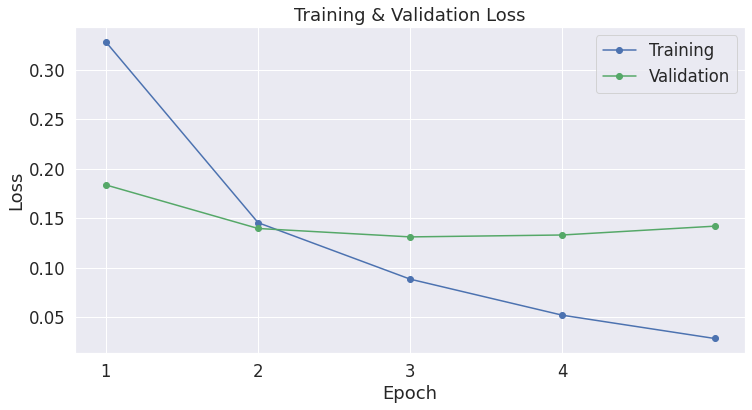

In [19]:
import matplotlib.pyplot as plt
% matplotlib inline
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [20]:
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

#Sauvegarder le modèle

In [21]:
import os

output_dir = '/content/drive/MyDrive/TER2021/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to /content/drive/MyDrive/TER2021/


('/content/drive/MyDrive/TER2021/tokenizer_config.json',
 '/content/drive/MyDrive/TER2021/special_tokens_map.json',
 '/content/drive/MyDrive/TER2021/vocab.json',
 '/content/drive/MyDrive/TER2021/merges.txt',
 '/content/drive/MyDrive/TER2021/added_tokens.json')

#Génération

In [22]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: This house believes that Israel's 2008-2009 military operations against Gaza were justified Life in the south under rocket barrages had become unbearable On February 17, 2008, John Holmes, United Nations Under-Secretary-General for Humanitarian  Affairs and Emergency Relief Coordinator said while visiting Sderot, "The people of Sderot and the surrounding area have had to live with these unacceptable and indiscriminate rocket attacks for seven years now. There is no doubt about the physical and psychological suffering these attacks are causing


1: This house believes that male infant circumcision is tantamount to child abuse Circumcision remains a relatively safe procedure According to an analysis of clinical trial data from the Pediatrics Journal, uncircumcised men were at a higher risk of developing balanitis than circumcised men [REF


2: This house would ban gambling Various forms of online gambling are legal and regulated in many countries In 